# インポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# データの用意

In [229]:
df = pd.read_csv("./data/^N225.csv")

df.index = pd.to_datetime(df["Date"])
df = df.drop(["Date"], axis=1)
df = df.dropna()
df['logr'] = (np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))) * 100.0
df = df.dropna()
train_df = df[(df.index.year>=2000) & (df.index.year<=2005)]
test_df = df[(df.index.year>=2006) & (df.index.year<=2010)]
train_logr = train_df['logr'].values
test_logr = test_df['logr'].values

In [230]:
n_state = 20
train_X = []
train_y = []
for i in range(len(train_logr) - n_state):
    train_X.append(train_logr[i:i+n_state])
    train_y.append(train_logr[i+n_state])
train_X = np.array(train_X)
train_y = np.array(train_y)

In [231]:
n_state = 20
test_X = []
test_y = []
for i in range(len(test_logr) - n_state):
    test_X.append(test_logr[i:i+n_state])
    test_y.append(test_logr[i+n_state])
test_X = np.array(test_X)
test_y = np.array(test_y)

# ネットワークの作成

In [251]:
class Network(nn.Module):
    def __init__(self, n_state):
        super(Network, self).__init__()
        self.n_state = n_state
        hidden_size = 100

        self.rnn = nn.RNN(self.n_state, 
                          hidden_size, 
                          num_layers=1,
                          dropout=0.5)

        self.out_layer = nn.Sequential(
            nn.Linear(100+1, 1),
        )

    def initHidden(self):
        self.c = torch.zeros(1, 1, 100)
    
    def forward(self, x, prev_act):
        h, c = self.rnn(x, self.c)
        self.c = c.clone().detach()
        h = torch.cat([h[0], prev_act], dim=1)
        z = torch.tanh(self.out_layer(h))
        return z

# 実行

In [252]:
# create network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network(n_state)
if device == 'cuda':
    net.cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

# Tensor 
train_X_var = torch.tensor(torch.from_numpy(train_X), device=device, dtype=torch.float)
train_y_var = torch.tensor(torch.from_numpy(train_y), device=device, dtype=torch.float).view(-1, 1)
test_X_var  = torch.tensor(torch.from_numpy(test_X), device=device, dtype=torch.float)
test_y_var  = torch.tensor(torch.from_numpy(test_y), device=device, dtype=torch.float).view(-1, 1)

# loss function
def sharpe_ratio(act_hist, target):
    R = act_hist[:-1] * train_y_var[:-1] - 1.0e-3*100*torch.abs(act_hist[1:] - act_hist[:-1])
    sharpe = torch.mean(R) / torch.std(R)
    return sharpe

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarn

In [ ]:
cumsum_list = []

writer = SummaryWriter('./logs')

action_space = 1
n_epochs = 500
for epoch in range(n_epochs):
    
    prev_act = torch.tensor([[0.0]])
    act_hist = torch.zeros(len(train_y_var)).view(-1, 1)
    net.initHidden()

    for i, X in enumerate(train_X_var):
        X = X.view(1,1,-1)

        if i % action_space == 0:
            act = net(X, prev_act)

        act_hist[i] = act
        prev_act = act

    sharpe = sharpe_ratio(act_hist, train_y_var)
    if epoch % 10 == 0:
        print('epoch: {} sharpe: {}'.format(epoch, sharpe.item()))

    # update parameter
    sharpe = -sharpe
    optimizer.zero_grad()
    sharpe.backward()
    optimizer.step()

epoch: 0 sharpe: -0.09288709610700607
epoch: 10 sharpe: 0.07625691592693329
epoch: 20 sharpe: 0.15375052392482758
epoch: 30 sharpe: 0.24914099276065826
epoch: 40 sharpe: 0.419140487909317
epoch: 50 sharpe: 0.5832639932632446
epoch: 60 sharpe: 0.7405966520309448
epoch: 70 sharpe: 0.8640815615653992
epoch: 80 sharpe: 0.9490194320678711
epoch: 90 sharpe: 0.9932540059089661
epoch: 100 sharpe: 1.0909680128097534
epoch: 110 sharpe: 1.1154804229736328
epoch: 120 sharpe: 1.1780731678009033
epoch: 130 sharpe: 1.1976479291915894
epoch: 140 sharpe: 1.265261173248291
epoch: 150 sharpe: 1.2872360944747925
epoch: 160 sharpe: 1.2663238048553467
epoch: 170 sharpe: 1.3043766021728516
epoch: 180 sharpe: 1.3425387144088745
epoch: 190 sharpe: 1.2947393655776978
epoch: 200 sharpe: 1.3248114585876465
epoch: 210 sharpe: 1.340320110321045
epoch: 220 sharpe: 1.4032721519470215
epoch: 230 sharpe: 1.3887159824371338
epoch: 240 sharpe: 1.4114954471588135
epoch: 250 sharpe: 1.3988122940063477
epoch: 260 sharpe: 1.

# 訓練期間

In [ ]:
net.eval()
train_act_hist = torch.zeros_like(train_y_var)
prev_act = torch.tensor([[0.0]])
net.initHidden()
for i, X in enumerate(train_X_var):
    X = X.view(1,1,-1)
    with torch.no_grad():
        act = net(X, prev_act)
    train_act_hist[i] = act

    prev_act = act

In [ ]:
plt.plot((train_act_hist * train_y_var).numpy().flatten().cumsum())

In [ ]:
plt.plot(train_y.cumsum())

In [ ]:
plt.plot(train_act_hist.flatten())
print('buy:  ', len(train_act_hist[train_act_hist>0]))
print('sell: ', len(train_act_hist[train_act_hist<0]))

# テスト期間

In [247]:
net.eval()
test_act_hist = torch.zeros_like(test_y_var)
prev_act = torch.tensor([[0.0]])
net.initHidden()
for i, X in enumerate(test_X_var):
    X = X.view(1,1,-1)
    with torch.no_grad():
        act = net(X, prev_act)
    test_act_hist[i] = act

    prev_act = act

buy:   620
sell:  583


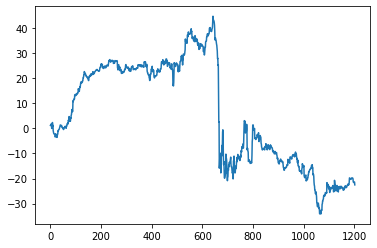

In [248]:
plt.plot((test_act_hist * test_y_var).numpy().flatten().cumsum())
print('buy:  ', len(test_act_hist[test_act_hist>0]))
print('sell: ', len(test_act_hist[test_act_hist<0]))

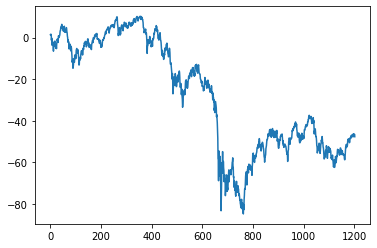

In [249]:
plt.plot(test_y.cumsum())

buy:   620
sell:  583


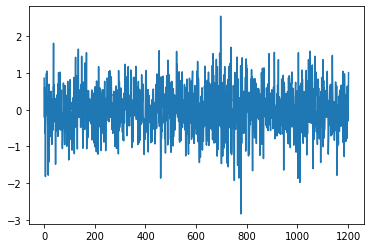

In [250]:
plt.plot(test_act_hist.flatten())
print('buy:  ', len(test_act_hist[test_act_hist>0]))
print('sell: ', len(test_act_hist[test_act_hist<0]))